# AdventureWorks Försäljningsanalys

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljning över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Bananasplit1988!")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde in ansluta", e)


Anslutning till SQL Server lyckades


C:\Users\Mauro\AppData\Local\Temp\ipykernel_20892\3284328489.py:21: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visulisering 1: Antal produkter per kategori

Hur många produkter finns i varje kategori?

Tabeller som använts:
- Production.ProductCategory, 
- Production.ProductSubcategory, 
- Production.Product

Plan:
- JOINA tabellerna
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultatet

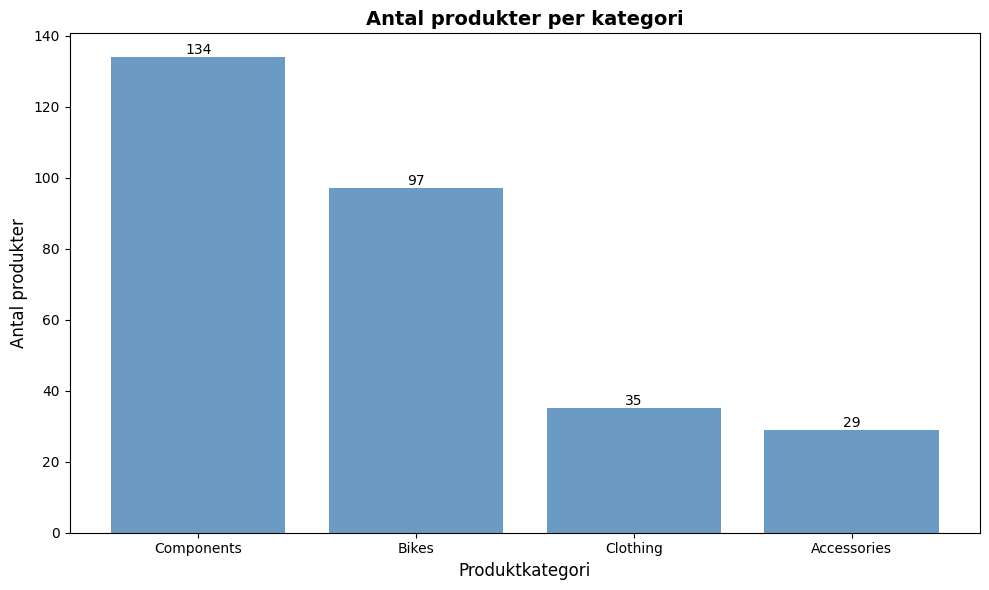

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""
df_vis1 = query_df(query_vis1)


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color= 'steelblue', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()





### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserad på komponenter och reservdelar. 
Ett potentiellt utvecklingsområde är kläder och accessoarer som är underrepresenterade här.

## Visulisering 2: Försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

Tabeller som använts:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
- JOINA tabellerna
- Räkna försäljningstotal per kategori
- Skapa horisontellt stapeldiagram
- Analysera resultatet

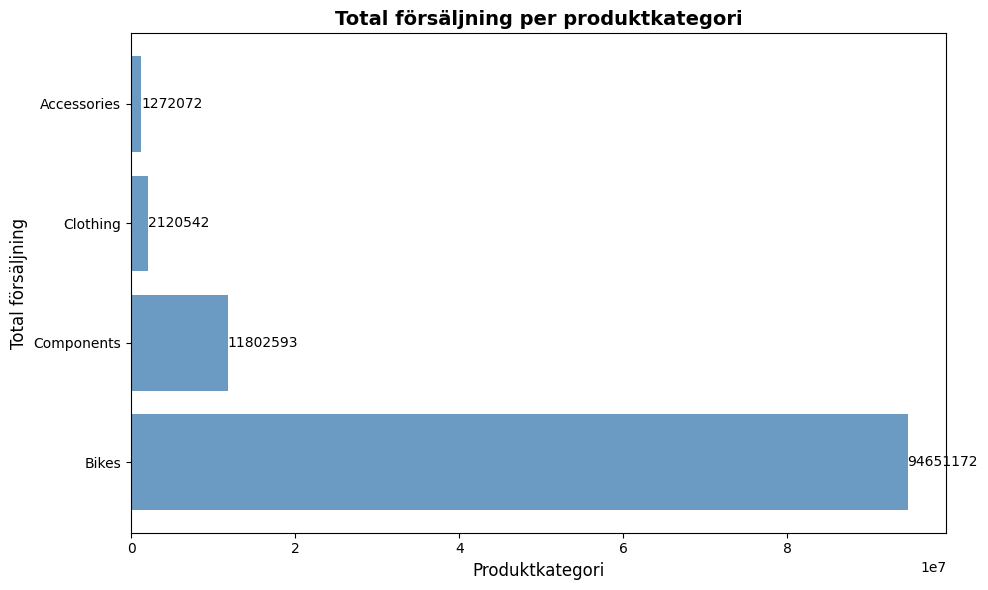

In [4]:
query_vis2 = """
SELECT 
    pc.Name AS CategoryName,
    SUM(so.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail so
    ON p.ProductID = so.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""
df_vis2 = query_df(query_vis2)


fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color= 'steelblue', alpha=0.8)


for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{int(width)}',
        ha= 'left',
        va = 'center'
    )


ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()


### Insikter -  Försäljning per produktkategori
Bikes har högst försäljningssiffror på 94 651 172, följt av Components och Clothing.
Accessories ligger längst ner på listan med 1 272 072.


Företaget är starkt fokuserad på komponenter och reservdelar som tidigare stapeldiagram visade oss och det syns även på försäljningssiffrorna. 
Både Clothing och Accessories har stor utvecklingspotential. 

## Visulisering 3: Försäljningstrend över tid

Hur har försäljningen utvecklats över tid?

Använt följande tabell: Sales.SalesOrderHeader

Plan:
- Räkna totalförsäljning per månad
- Filtrera på försäljningssiffror från 2024
- Skapa linjediagram
- Analysera resultatet

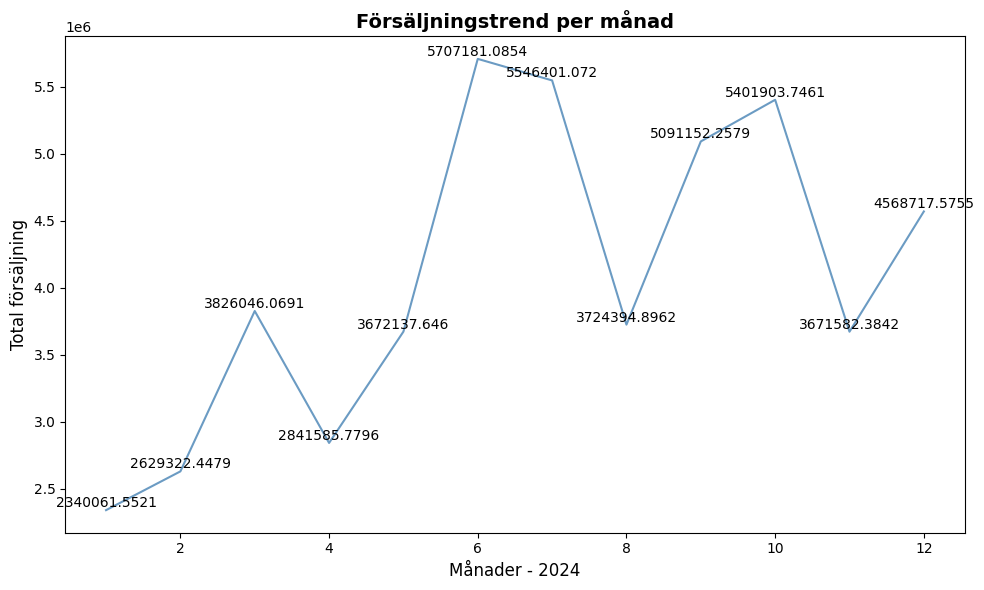

In [5]:
query_vis3 = """
SELECT
    MONTH(OrderDate) AS Month,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader soh
WHERE DATEPART(year, OrderDate) = 2024
GROUP BY MONTH(OrderDate)
ORDER BY MONTH(OrderDate) ASC;
"""
df_vis3 = query_df(query_vis3)


fig, ax = plt.subplots(figsize=(10,6))

line, = ax.plot(df_vis3['Month'], df_vis3['TotalSales'], color= 'steelblue', alpha=0.8)

for x,y in zip(line.get_xdata(), line.get_ydata()):
    ax.text(
        x,y,
        f'{y}',
        ha='center',
        va='bottom'
    )

ax.set_xlabel('Månader - 2024', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - Försäljningstrend över tid
Det är tydligt att försäljningstrenden under 2024 börjar långsamt med den lägsta sifffran i Januari - 2 340 061. Trenden är väldigt oregelbunden månad till månad men den pekar fortsatt uppåt med Juni som högsta punkten på 5 707 181. 
Med ett sådant ojämnt mönster i försäljningen är det svårt att följa påverkan eller inverkan. Djupare studier rekommenderas. 


## Visulisering 4: Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

Använt följande tabell: Sales.SalesOrderHeader

Plan:
Räkna total antal ordrar samt total försäljning
Gruppera på år
Skapa grupperat stapeldiagram med .twinx() för att kunna visualisera antal ordrar ihop med total försäljning.
Analysera resultatet

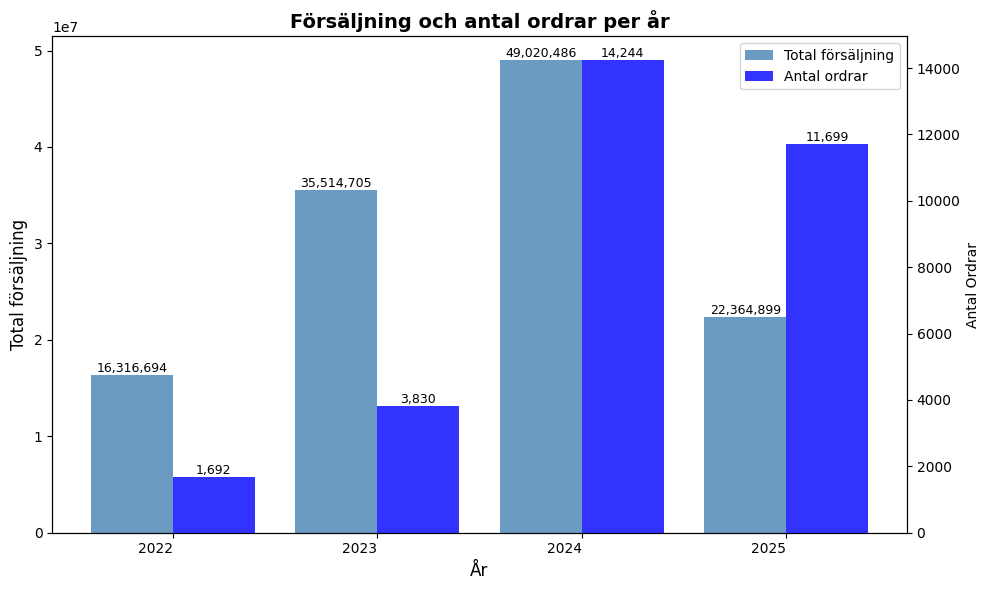

In [6]:
query_vis4 = """
SELECT
    DATEPART(year, OrderDate) AS SalesYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS TotalOrders
FROM Sales.SalesOrderHeader
GROUP BY DATEPART(year, OrderDate)
ORDER BY DATEPART(year, OrderDate) ASC;
"""
df_vis4 = query_df(query_vis4)


fig, ax1 = plt.subplots(figsize=(10,6))
width = 0.40
x = df_vis4['SalesYear']

ax1.bar(df_vis4['SalesYear']-0.2, df_vis4['TotalSales'],width, color= 'steelblue', alpha=0.8, label='Total försäljning')

ax1.set_ylabel('Total försäljning', fontsize=12)
ax1.set_xlabel('År', fontsize=12)
ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight = 'bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['SalesYear'], ha='right')

ax2 = ax1.twinx()

ax2.bar(df_vis4['SalesYear']+0.2, df_vis4['TotalOrders'], width, color= 'blue', alpha=0.8, label='Antal ordrar')
ax2.set_ylabel('Antal Ordrar')

for xi, val in zip(x - width/2, df_vis4['TotalSales']):
    ax1.text(
        xi, val, 
        f'{int(val):,}', 
        ha='center', 
        va='bottom', 
        fontsize=9
        )
    
for xi, val in zip(x + width/2, df_vis4['TotalOrders']):
    ax2.text(
        xi, val, 
        f'{int(val):,}',
        ha='center',
        va='bottom', 
        fontsize=9
        )


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)


plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal ordrar per år

Om vi jämför försäljning mot antal ordrar är det svårt att se en exakt trend - 2022s siffror fördubblas nästan i 2023 men båda har väldigt låga antal ordrar i jämförelse med försäljningssiffrorna. Det dem 2 åren har i gemensamt är att ordrar ligger på 0.01% av försäljningen. 
2024 har dem högsta siffrorna både i försäljning och antal ordrar och ordrar ligger nu på 0.029% av försäljningsvärdet så mer billigare ordrar har gjorts.
2025 dras siffrorna ner igen men än konstigare är att ordervärde ligger nu på 0.05% av försäljningsvärdet. Orderantal har gått ner men inte i samma takt som försäljningen. Kan ha att göra med att vi inte fått in än alla siffror för detta år. 


## Visulisering 5: Top 10 produkter

Vilka 10 produkter genererar mest försäljning?

Tabeller som använts:
- Production.Product
- Sales.SalesOrderDetail

Plan:
- Välja Top 10
- JOINA tabellerna
- Räkna ut total försäljning
- Grupperna enligt kategori
- Skapa horisontellt stapeldiagram
- Analysera resultatet

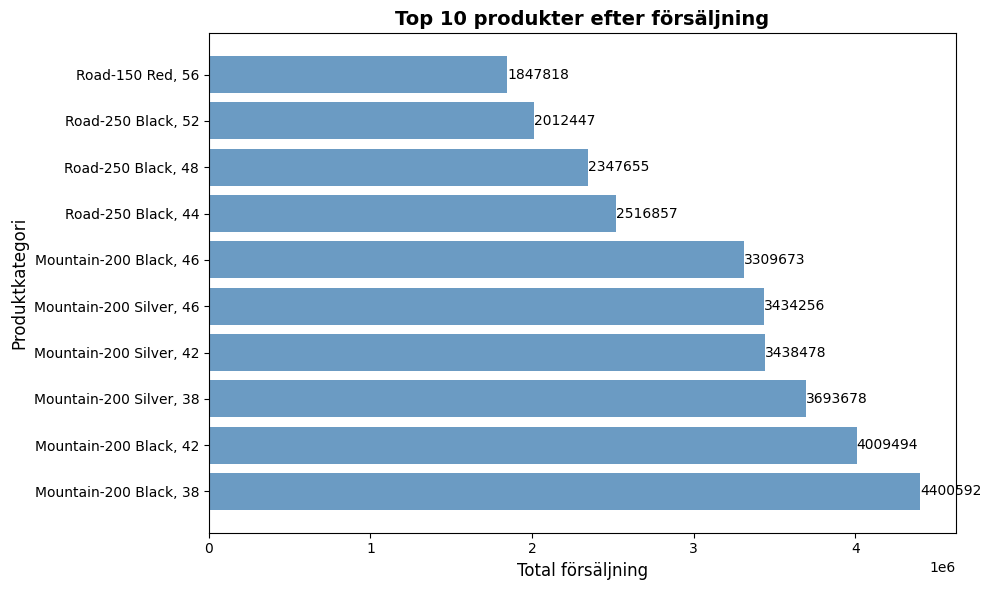

In [7]:
query_vis5 = """
SELECT TOP (10)
    p.Name AS ProductCategory,
    SUM(so.LineTotal) AS TotalSales    
FROM Production.Product p
INNER JOIN Sales.SalesOrderDetail so
    ON p.ProductID = so.ProductID
GROUP BY p.Name
ORDER BY SUM(so.LineTotal) DESC;
"""
df_vis5 = query_df(query_vis5)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis5['ProductCategory'], df_vis5['TotalSales'], color= 'steelblue', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{int(width)}',
        ha= 'left',
        va = 'center'
    )


ax.set_xlabel('Total försäljning', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter -  Vilka 10 produkter genererar mest försäljning?
I enlighet med företagets fokus så är dem top 10 kategorierna alla inom Bikes - den största säljaren är Mountain-200 Black, 38 med 4 400 592 i total försäljning.
Det är tydligt att Mountain kategorin säljer bäst eftersom den representerar 60% av dem top 10 produkterna. 

## Visulisering 6: Försäljning och antal kunder per region

Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som använts:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

Plan:
- JOINA tabellerna
- Räkna ut antal kunder
- Summera ihop total försäljning
- Skapa grupperat stapeldiagram med hjälp av twinx().
- Analysera resultatet

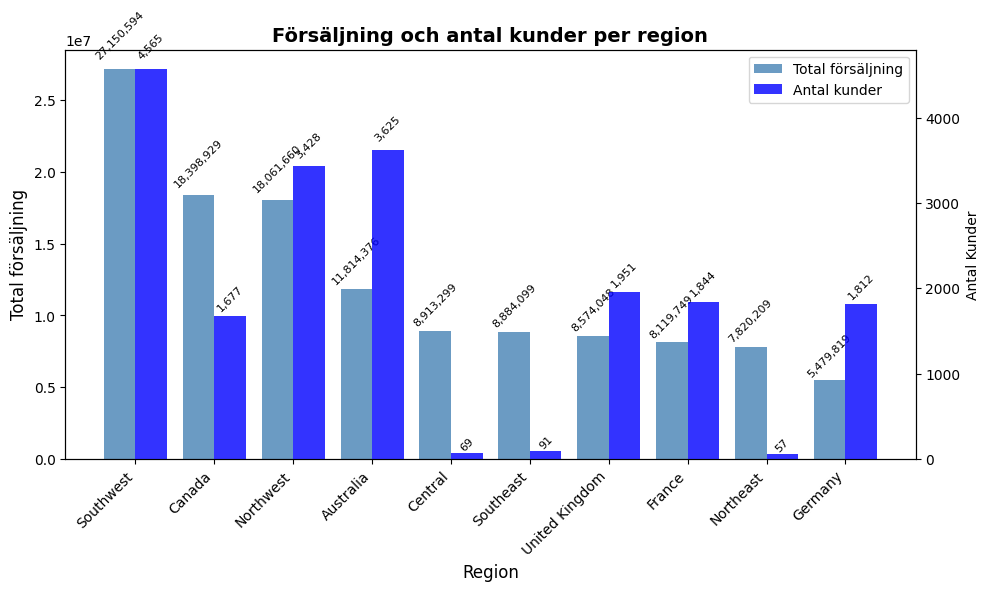

In [8]:
query_vis6 = """
SELECT 
    st.Name AS Regions,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT sc.CustomerID) AS TotalClients 
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer sc
    ON soh.CustomerID = sc.CustomerID
GROUP BY st.Name
ORDER BY SUM(soh.TotalDue) DESC;
"""
df_vis6 = query_df(query_vis6)



fig, ax1 = plt.subplots(figsize=(10,6))
width = 0.40

x = np.arange(len(df_vis6))
labels = df_vis6['Regions']

ax1.bar(x - width/2, df_vis6['TotalSales'],width, color= 'steelblue', alpha=0.8, label='Total försäljning')

ax1.set_ylabel('Total försäljning', fontsize=12)
ax1.set_xlabel('Region', fontsize=12)
ax1.set_title('Försäljning och antal kunder per region', fontsize=14, fontweight = 'bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6['Regions'], ha='right', rotation=45)

ax2 = ax1.twinx()

ax2.bar(x + width/2, df_vis6['TotalClients'], width, color= 'blue', alpha=0.8, label='Antal kunder')
ax2.set_ylabel('Antal Kunder')

for xi, val in zip(x - width/2, df_vis6['TotalSales']):
    ax1.text(
        xi, val + val*0.02, 
        f'{int(val):,}', 
        ha='center', 
        va='bottom', 
        fontsize=8,
        rotation=45
        )
    
for xi, val in zip(x + width/2, df_vis6['TotalClients']):
    ax2.text(
        xi, val + val*0.02, 
        f'{int(val):,}',
        ha='center',
        va='bottom', 
        fontsize=8,
        rotation=45
        )


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)

plt.tight_layout()
plt.show()

### Insikter - Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Den starkaste regionen när det kommer till både försäljning och antal kunder är Southwest som leder med 27 150 594 i total försäljning och 4 565 kunder. 
För resterande regioner verkar det inte vara samma tydliga korrelation mellan kunder och försäljningssiffror. Om vi tittar på dem regionerna som ligger omkring 8 000 000 (Central, Southeast, United Kindom, France, Northeast) ser man stor variation på antalet kunder - var som helst mellan 69-1 951. Så ingen tydlig trend mellan ordervärde och antal kunder. Rekommenderar djupare studier i det här området. 

## Visulisering 7: Genomsnittligt ordervärde per region och kundtyp

Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som använts:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

Plan:
- JOINA tabellerna
- Summera total försäljning delat på antal ordrar för varje kundtyp(privat/företag)
- Räkna ihop total försäljning delat på totalt antal kunder så resultat kan sorteras på det. 
- Skapa grupperat stapeldiagram
- Analysera resultatet

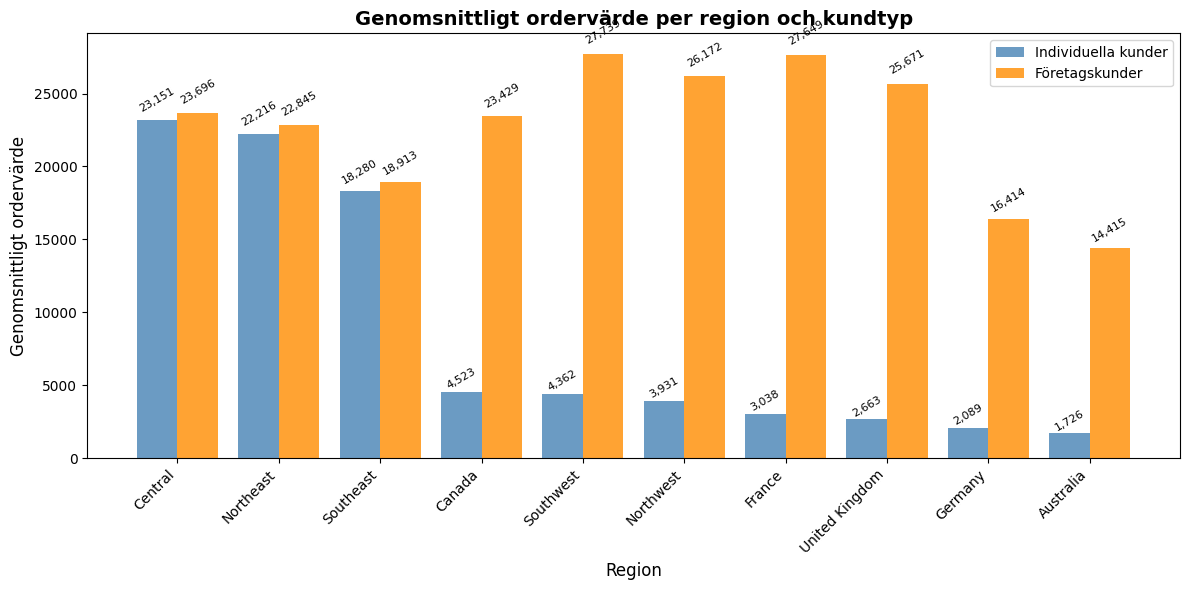

In [9]:
query_vis7 = """
SELECT
    st.Name AS Region,
    SUM(CASE WHEN sc.PersonID IS NOT NULL THEN so.TotalDue END)
    / NULLIF(COUNT(CASE WHEN sc.PersonID IS NOT NULL THEN so.SalesOrderID END),0)
    AS AvgOrderValue_Individual,
    SUM(CASE WHEN sc.StoreID IS NOT NULL THEN so.TotalDue END)
    / NULLIF(COUNT(CASE WHEN sc.StoreID IS NOT NULL THEN so.SalesOrderID END),0)
    AS AvgOrderValue_Store,
    SUM(so.TotalDue) * 1.0 / COUNT(so.SalesOrderID) AS AvgOrderValue_Total
FROM Sales.SalesTerritory st 
INNER JOIN Sales.SalesOrderHeader so
    ON st.TerritoryID = so.TerritoryID
INNER JOIN Sales.Customer sc
    ON so.CustomerID = sc.CustomerID
LEFT JOIN Sales.Store s
    ON sc.StoreID = s.BusinessEntityID
GROUP BY st.Name
ORDER BY AvgOrderValue_Total DESC;   
"""
df_vis7 = query_df(query_vis7)

fig, ax = plt.subplots(figsize=(12,6))
width = 0.40

x = np.arange(len(df_vis7))
labels = df_vis7['Region']

ax.bar(x - width/2, df_vis7['AvgOrderValue_Individual'],width, color= 'steelblue', alpha=0.8, label='Individuella kunder')
ax.bar(x + width/2, df_vis7['AvgOrderValue_Store'], width, color='darkorange', alpha=0.8, label='Företagskunder')

ax.set_ylabel('Genomsnittligt ordervärde', fontsize=12)
ax.set_xlabel('Region', fontsize=12)
ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight = 'bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, ha='right', rotation=45)

for xi, val in zip(x - width/2, df_vis7['AvgOrderValue_Individual']):
    ax.text(
        xi, val + val*0.02, 
        f'{int(val):,}', 
        ha='center', 
        va='bottom', 
        fontsize=8,
        rotation=30
        )
    
for xi, val in zip(x + width/2, df_vis7['AvgOrderValue_Store']):
    ax.text(
        xi, val + val*0.02, 
        f'{int(val):,}',
        ha='center',
        va='bottom', 
        fontsize=8,
        rotation=30
        )


ax.legend()

plt.tight_layout()
plt.show()

### Insikter - Genomsnittligt ordervärde per region och kundtyp

Det är utan undantag företagskunder som har högst ordervärde igenom alla regioner. 
Central, Northeast och Southeast har dem högst siffrorna på individuella kunder men är ändå mindre än företagskunderna. 
Med tanke på att företagets fokus ligger på Bikes och components är det möjligt att individer köper mest av detta i regioner som inte har lika mycket val till kollektivtraffik. I länder med kollektivtraffik som Germany, United Kingdom, etc. är det mer företag som köper dessa. Kan också handla om kulturella skillnader i val mellan motorcyklar och bilanvändning.
Dessa skillnader pekar på oforskade marknader i dem regioner där privatkunder ligger lågt - en möjlighet att utreda anledningen till skillnaderna och vad för alternativ som kan skapas från företaget. 